5725
9070 events
is car


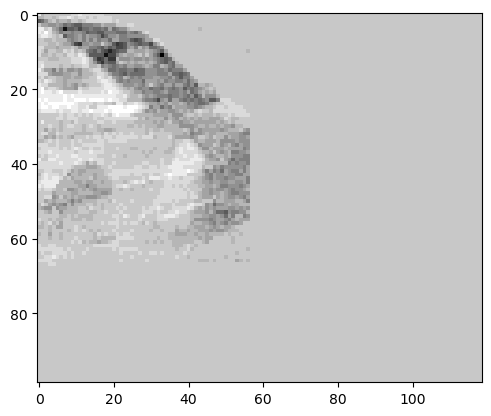

/tmp/ipykernel_207283/414811924.py:181: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


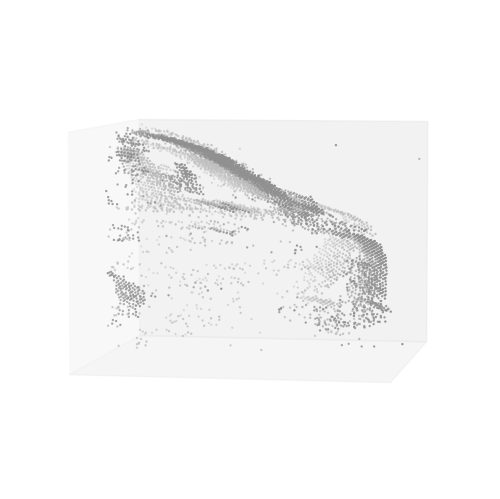

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
from PIL import Image, ImageDraw
import struct


def load_ncal(raw_file: str):
    f = open(raw_file, 'rb')
    raw_data = np.fromfile(f, dtype=np.uint8)
    f.close()

    raw_data = np.uint32(raw_data)
    all_y = raw_data[1::5]
    all_x = raw_data[0::5]
    all_p = (raw_data[2::5] & 128) >> 7  # bit 7
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
    all_ts = all_ts / 1e6  # µs -> s
    all_p = all_p.astype(np.float64)
    all_p[all_p == 0] = -1
    events = np.column_stack((all_x, all_y, all_ts, all_p))

    events = events[:16000, :]

    return events

def load_atis_data(filename, flipX=0, flipY=0):
    td_data = {'ts': [], 'x': [], 'y': [], 'p': []}
    header = []

    with open(filename, 'rb') as f:
        # Parse header if any
        endOfHeader = False
        numCommentLine = 0
        while not endOfHeader:
            bod = f.tell()
            tline = f.readline().decode('utf-8', errors='ignore')
            if tline[0] != '%':
                endOfHeader = True
            else:
                words = tline.split()
                if len(words) > 2:
                    if words[1] == 'Date':
                        if len(words) > 3:
                            header.append((words[1], words[2] + ' ' + words[3]))
                    else:
                        header.append((words[1], words[2]))
                numCommentLine += 1
        f.seek(bod)

        evType = 0
        evSize = 8
        if numCommentLine > 0:  # Ensure compatibility with previous files.
            # Read event type
            evType = struct.unpack('b', f.read(1))[0]
            # Read event size
            evSize = struct.unpack('b', f.read(1))[0]

        bof = f.tell()
        f.seek(0, 2)
        numEvents = (f.tell() - bof) // evSize

        # Read data
        f.seek(bof)  # Start just after the header
        for _ in range(numEvents):
            timestamp = struct.unpack('<I', f.read(4))[0]
            timestamp *= 1e-6  # us -> s
            addr = struct.unpack('<I', f.read(4))[0]
            x = (addr & 0x00003FFF) >> 0
            y = (addr & 0x0FFFC000) >> 14
            p = (addr & 0x10000000) >> 28

            td_data['ts'].append(timestamp)
            td_data['x'].append(x if flipX == 0 else flipX - x)
            td_data['y'].append(y if flipY == 0 else flipY - y)
            td_data['p'].append(p)

    return td_data, header

def show_events(mode: str = 'test', seq: int = 0):
    path = f"/space/yyang22/datasets/data/storage/ncars/{mode}/sequence_{seq}/"
    # path = "/space/yyang22/datasets/data/storage/ncars/training/sequence_7/"
    events = np.loadtxt(path+'events.txt')
    is_car = np.loadtxt(path+'is_car.txt')

    # import os
    # import random
    # folder_path = "/users/yyang22/thesis/datasets/original_ncars/Prophesee_Dataset_n_cars/n-cars_train/cars/"
    # files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # # file_name = random.choice(files)
    # file_name = 'obj_006961_td.dat'
    # print(f'Current file: {file_name}')
    # file_path = os.path.join(folder_path, file_name)

    # td_data,_ = load_atis_data(file_path)
    # is_car = 1

    # specified_order = ['x','y','ts','p']
    # events = np.array([td_data[key] for key in specified_order], dtype=object).T


    events_x = events[:,0].astype(int)
    events_y = events[:,1].astype(int)
    max_x = events_x.max()
    max_y = events_y.max()
    # if abs(max_x - 119) > 0.5:
    #     return max_x
    events_t = events[:,2]
    events_p = (events[:,3] - 0.5)*2
    # events_p = events[:,3]
    # print(events_p)
    events_point = events[:,0:2].astype(int)


    print(f'{len(events)} events')
    if is_car == 1: print('is car')
    else: print('not car')

    # grid_x = np.arange(0, max_x+1, 1)
    # grid_y = np.arange(0, max_y+1, 1)
    # h = np.zeros((max_x+1, max_y+1))

    h = np.zeros((120,100))

    for i in range(events_point.shape[0]):
        idx_x = events_point[i,0]
        idx_y = events_point[i,1]
        h[idx_x,idx_y] += events_p[i]

    # for i in range(1000):
    #     idx_x = events_point[i,0]
    #     idx_y = events_point[i,1]
    #     h[idx_x,idx_y] += events_p[i]

    # Method 1
    # fig,ax = plt.subplots()
    # # levels = ((h.max()-h.min())*10).astype(int)
    # levels = 1000
    # # ax = plt.contourf(h.T, levels=levels, cmap='gray')
    # ax.contourf(h.T, levels=levels, cmap='gray')
    # # ax.axis('scaled')
    # ax.set_xlim(0,119)
    # ax.set_ylim(0,99)
    # ax.invert_yaxis()
    # # cbar = plt.colorbar()
    # plt.show()


    min_value = h.min()
    max_value = h.max()
    max_abs = max(abs(min_value), abs(max_value))

    # pad with squares
    width, height = 119, 99
    # width, height = max_x, max_y
    image = Image.new('L', (width, height))
    draw = ImageDraw.Draw(image)
    for x in range(width):
        for y in range(height):
            value = h[x, y]
            gray_value = int(255 * (value - min_value) / (max_value - min_value))
            draw.rectangle([x, y, x + 1, y + 1], fill=gray_value)

    plt_image = plt.imshow(image, cmap='gray')
    plt.show()


    # fig 2

    events = events[:5000,:]

    colors = []
    for i in range(events.shape[0]):
        # color = '#00FF00' if events[i,3] == 1 else '#FF0000'
        color = '#C0C0C0' if events[i,3] == 1 else '#909090'
        colors.append(color)
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlim(0,np.max(events[:,0]))
    ax.set_zlim(0,np.max(events[:,1]))
    ax.invert_zaxis()
    ax.set_ylim(-0.1,0)
    # ax.set_ylim(ax.get_ylim()[::-1])

    # def update(n):
    #     x = events[n,0]
    #     y = events[n,1]
    #     t = -events[n,2]
    #     c = colors[n]
    #     ax.scatter(x, t, y, c=c, s=0.5)
    # ani = FuncAnimation(fig, update, events.shape[0], interval=100)
    # ani.save('scatter.gif', writer='pillow')

    ax.scatter(events[:,0], -events[:,2], events[:,1], c=colors, s=0.5)

    ax.view_init(elev=5, azim=-80)
    ax.grid(False)
    # ax.set_xlabel('x', labelpad=-20)
    # ax.set_ylabel('t', labelpad=-15)
    # ax.set_zlabel('y', labelpad=-20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis._axinfo['juggled'] = (0,0,1)
    ax.yaxis._axinfo['juggled'] = (1,1,0)
    ax.zaxis._axinfo['juggled'] = (2,2,0)

    print(ax.spines)

    # ax.text(0, 0, 0, "x")
    # ax.text(0, -0.1, 0, "y")
    # ax.text(0, 0, 10, "t")


    # ax.tick_params(axis='x', labelsize=0)
    # ax.tick_params(axis='y', labelsize=0)
    # ax.tick_params(axis='z', labelsize=0)
    # ax.legend()

    plt.savefig(f'/users/yyang22/thesis/aegnn_project/aegnn_results/ncars_dots_{id}_no_label.svg', format='svg')
    plt.savefig(f'/users/yyang22/thesis/aegnn_project/aegnn_results/ncars_dots_{id}_no_label.png', format='png')
    plt.show()

    return max_x

# for i in trange(4289,8600):
#     max_x = show_events('training', i)
#     if abs(max_x - 119) > 0.5:
#         continue
#     else:
#         print(f'sample {i} with max_x {max_x}')
#         break


import numpy as np
# id = np.random.randint(8001)
# id = np.random.randint(999)
id = 5725
print(id)
max_x = show_events('training', id)

# is car: 676, 7627, 2235, 5725

# is car original: obj_006961


['r', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'r', 'r', 'b', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b',

/tmp/ipykernel_2714231/4292308273.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


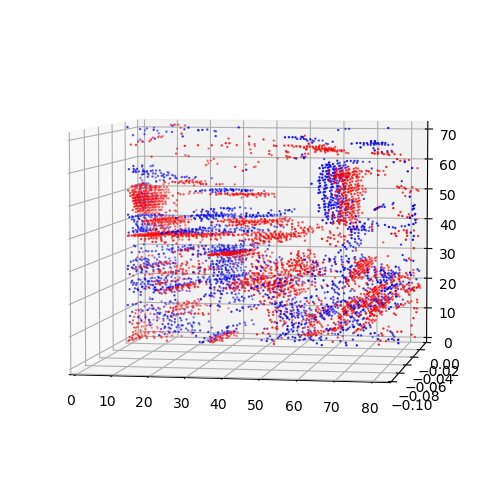

In [77]:
path = f"/space/yyang22/datasets/data/storage/ncars/training/sequence_2235/"
# path = "/space/yyang22/datasets/data/storage/ncars/training/sequence_7/"
events = np.loadtxt(path+'events.txt')
is_car = np.loadtxt(path+'is_car.txt')

events = events[:5000,:]

colors = []
for i in range(events.shape[0]):
    color = 'b' if events[i,3] == 1 else 'r'
    colors.append(color)
print(colors)
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlim(0,np.max(events[:,0]))
ax.set_zlim(0,np.max(events[:,1]))
ax.set_ylim(-0.1,0)

# def update(n):
#     x = events[n,0]
#     y = events[n,1]
#     t = -events[n,2]
#     c = colors[n]
#     ax.scatter(x, t, y, c=c, s=0.5)
# ani = FuncAnimation(fig, update, events.shape[0], interval=100)
# ani.save('scatter.gif', writer='pillow')

ax.scatter(events[:,0], -events[:,2], events[:,1], c=colors, s=0.5)

ax.view_init(elev=5, azim=-80)

plt.show()

# fig, ax = plt.subplots()
# ax.scatter(events[:,0], events[:,1], c=colors[:], s=0.5, alpha=0.1)
# plt.show()

Data(x=[9070, 1], pos=[9070, 3], file_id='sequence_5725', label=[1], y=[1], edge_index=[2, 132675])


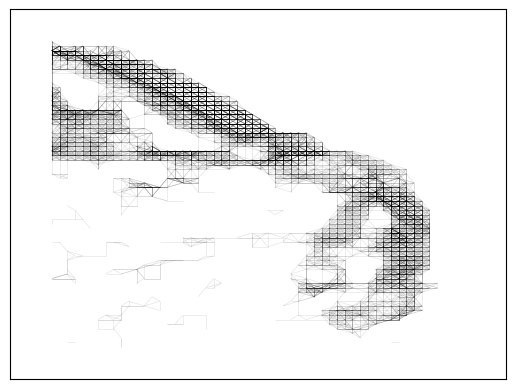

In [2]:
import torch
import torch_geometric
import aegnn
from torch_geometric.data import Data


def printg(graph):
    import networkx as nx
    from torch_geometric.utils import to_networkx
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    graph.pos = graph.pos[:,:2]
    pos_y_max = graph.pos[:,1].max()
    graph.pos[:,1] = pos_y_max - graph.pos[:,1]
    g_nx = to_networkx(graph, to_undirected=True)
    pos = dict(zip(np.arange(graph.num_nodes),graph.pos.tolist()))
    nx.draw_networkx(g_nx, pos=pos, with_labels=False, ax=ax, node_size=0, node_shape='o',  font_size=0, font_color='w',  edge_color='black', width=0.5, alpha=0.1)
    # nx.draw_networkx(g_nx, with_labels=False, ax=ax, node_size=1, node_shape='o',  font_size=8, font_color='w',  edge_color='b', width=1)
    plt.savefig('/users/yyang22/thesis/aegnn_project/aegnn_results/ncars_graph_5725.png', format='png')
    plt.savefig('/users/yyang22/thesis/aegnn_project/aegnn_results/ncars_graph_5725.svg', format='svg')

path = "/space/yyang22/datasets/data/storage/ncars/processed/training/sequence_5725"
ncars_sample = torch.load(path)
print(ncars_sample)

def random_node_sample(graph_data, ratio=0.5):
    num_nodes = graph_data.num_nodes
    sampled_nodes = torch.randperm(num_nodes)[:int(ratio * num_nodes)]
    sampled_data = graph_data.subgraph(sampled_nodes)
    # sampled_data = torch_geometric.utils.subgraph(sampled_nodes, graph_data)
    return sampled_data

sub = random_node_sample(ncars_sample)
sub2 = ncars_sample.subgraph(torch.arange(0, 2500))
# print(sub)
# print(sub2)

# printg(ncars_sample)
# printg(sub)
printg(sub2)